In [1]:
import ibmseti
import os
%matplotlib inline
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import zipfile

from scipy.fftpack import rfft, irfft, fftfreq

In [1]:
#If you are running this in IBM Apache Spark (via Data Science Experience)
base_url = 'https://dal05.objectstorage.service.networklayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'

#ELSE, if you are outside of IBM:
#base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'

mydatafolder = os.path.join( os.environ['PWD'], 'my_data_folder' )
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)

basic_container = 'simsignals_basic_v2'
basic4_zip_file = 'primary_testset_final_v3.zip'
os.system('curl {}/{}/{} > {}'.format(base_url, basic_container, basic4_zip_file, mydatafolder + '/' + basic4_zip_file))

!ls -al my_data_folder/primary_testset_final_v3.zip

-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 1157840757 Jul 20 15:38 my_data_folder/basic4.zip


In [2]:
!ls -al "$mydatafolder"

ls: cannot access : No such file or directory


In [5]:
zz = zipfile.ZipFile(mydatafolder + '/' + 'basic4.zip')
basic4list = zz.namelist()
print len(basic4list)

4000


In [16]:
index = 52
firstfile = basic4list[index]
print firstfile

0440e593-030b-438a-9666-b756f6397aab.dat


In [17]:
basic4list.index("0440e593-030b-438a-9666-b756f6397aab.dat")

52

In [18]:
aca = ibmseti.compamp.SimCompamp(zz.open(firstfile).read())
aca.header()

{u'signal_classification': u'squiggle',
 u'uuid': u'0440e593-030b-438a-9666-b756f6397aab'}

(32, 6144)


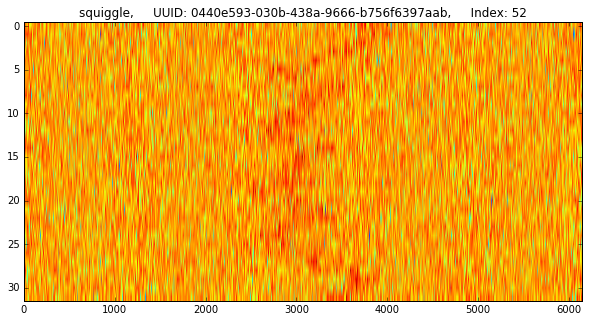

In [19]:
## ibmseti.compamp.SimCompamp has a method to calculate the spectrogram for you (without any signal 
## processing applied to the time-series data)
spectrogram = aca.get_spectrogram()
print spectrogram.shape
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram),  aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
plt.title('%s,     UUID: %s,     Index: %s'%(aca.header()['signal_classification'],aca.header()['uuid'],index))

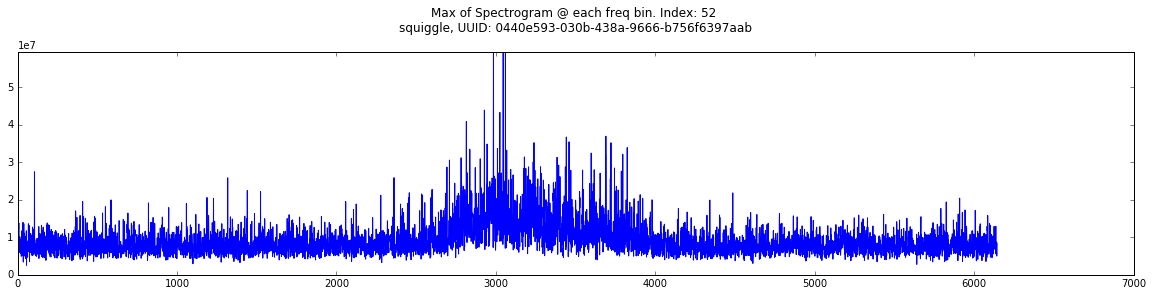

In [20]:
plt.figure(figsize=(20,4))
plt.plot(spectrogram.max(axis=0))
plt.ylim([0,spectrogram.max()])
plt.title('Max of Spectrogram @ each freq bin. Index: %s \n%s, UUID: %s\n'%(index, aca.header()['signal_classification'],aca.header()['uuid']))   

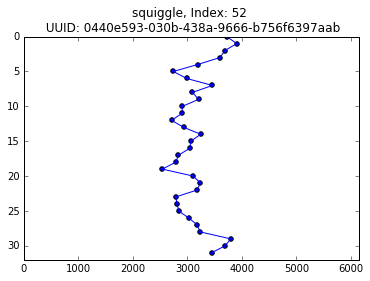

In [21]:
MaxAmps_Freq = spectrogram.argmax(1)
MaxAmps_Time = np.arange(32)

plt.plot(MaxAmps_Freq, MaxAmps_Time)
plt.scatter(MaxAmps_Freq, MaxAmps_Time)
plt.xlim([0,6144])
plt.ylim([32,0])
plt.title('%s, Index: %s \n UUID: %s'%(aca.header()['signal_classification'],index,aca.header()['uuid']))

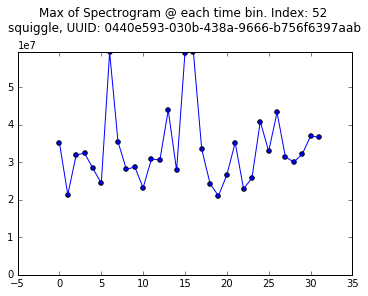

In [22]:
MaxAmps = spectrogram.max(axis=1)

plt.plot(MaxAmps)
plt.scatter(MaxAmps_Time,MaxAmps)
plt.ylim([0,spectrogram.max()])
plt.title('Max of Spectrogram @ each time bin. Index: %s \n%s, UUID: %s\n'%(index, aca.header()['signal_classification'],aca.header()['uuid']))   

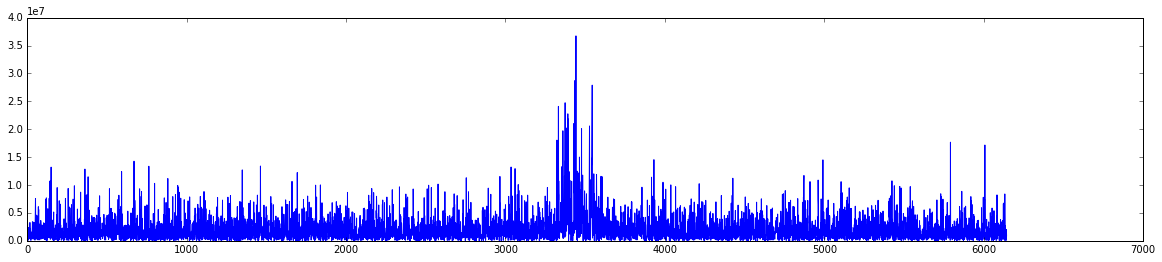

In [23]:
# Check out how one signal looks
plt.figure(figsize=(20,4))
plt.plot(spectrogram[31])

In [32]:
# Fourth attempt: use a smoothing function
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

(0, 20000000000.0)

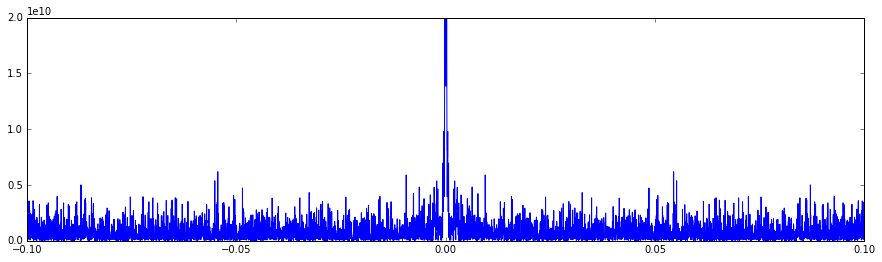

In [24]:
# First attempt: FFT #1
n = spectrogram[20].shape[0]
dx = 5.0    # Sampling period
Fk = fft.fft(spectrogram[0])/n    # Fourier coefficients (divided by n)
nu = fft.fftfreq(n,dx)  # Natural frequencies
Fk = fft.fftshift(Fk)   # Shift zero freq to center
nu = fft.fftshift(nu)   # Shift zero freq to center
plt.figure(figsize=(15,4))
plt.plot(nu, np.absolute(Fk)**2)  # Plot spectral power
plt.ylim([0,2e10])
#plt.xlim([-0.01,0.01])

In [25]:
# Second attempt: FFT #2 - FFT, filter, inv.FFT
time = np.linspace(0,spectrogram[0].shape[0],spectrogram[0].shape[0])
signal = spectrogram[4]
W = fftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

cut_f_signal = f_signal.copy()
cut_f_signal[np.logical_and(W>-0.001, W<0.5)] = 0 #0.05, Remove central freq
cut_signal = irfft(cut_f_signal)

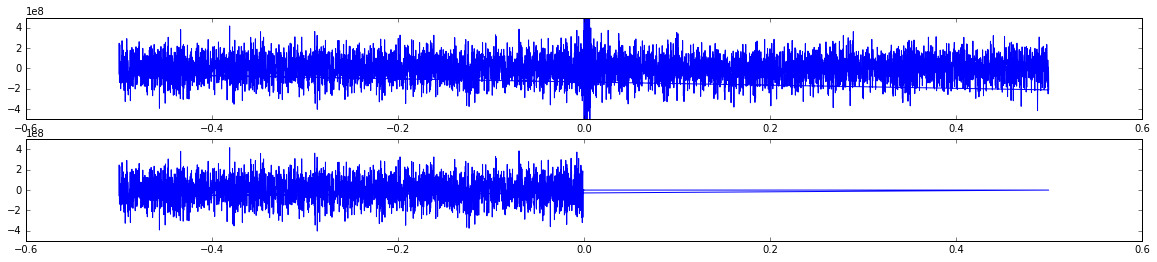

In [26]:
plt.figure(figsize=(20,4))
plt.subplot(211)
plt.plot(W,f_signal)
#plt.xlim([-1,1])
plt.ylim([-0.5e9,0.5e9])
plt.subplot(212)
plt.plot(W,cut_f_signal)
#plt.ylim([-1500,3000])
plt.show()

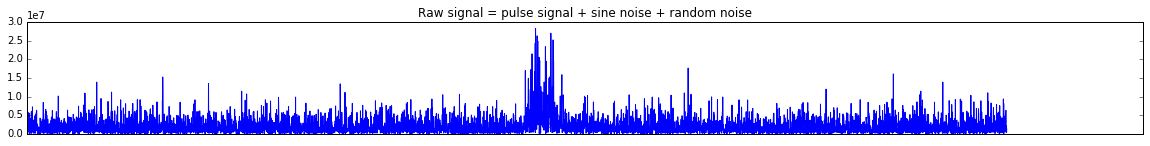

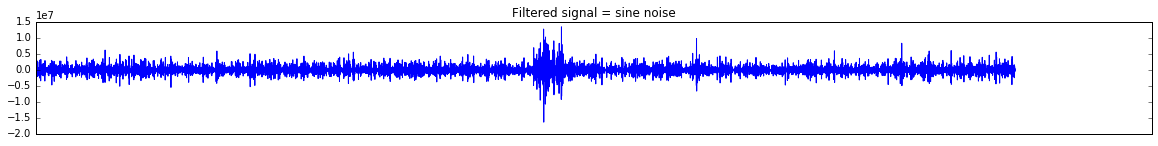

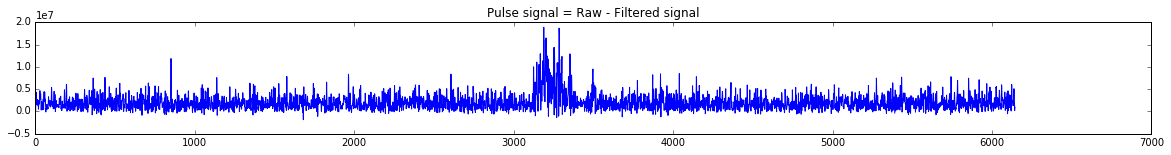

In [27]:
plt.figure(figsize=(20,2))
plt.plot(time,signal)
plt.title('Raw signal = pulse signal + sine noise + random noise')
plt.xticks([])

plt.figure(figsize=(20,2))
plt.plot(time,cut_signal) 
plt.title('Filtered signal = sine noise')
plt.xticks([])

plt.figure(figsize=(20,2))
plt.plot(time,signal-cut_signal)
plt.title('Pulse signal = Raw - Filtered signal')
#plt.xlim([2.5,3])

In [28]:
# Try "Second attempt" from above over entire spectrogram
spect_fftDSP = np.zeros(spectrogram.shape)
for cnt in range(32):
    signal = spectrogram[cnt]
    W = fftfreq(signal.size, d=time[1]-time[0])
    f_signal = rfft(signal)

    cut_f_signal = f_signal.copy()
    cut_f_signal[np.logical_and(W>-0.05, W<0.05)] = 0 #0.05, Remove central freq
    cut_signal = irfft(cut_f_signal)
    spect_fftDSP[cnt] = signal - cut_signal

/usr/local/src/bluemix_jupyter_bundle.v53/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


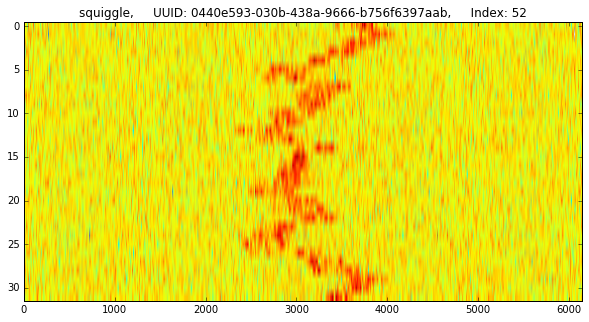

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spect_fftDSP),  aspect = 0.5*float(spect_fftDSP.shape[1]) / spect_fftDSP.shape[0])#, cmap=plt.get_cmap('gray'))
plt.title('%s,     UUID: %s,     Index: %s'%(aca.header()['signal_classification'],aca.header()['uuid'],index))

In [30]:
print aca.header()['uuid']

0440e593-030b-438a-9666-b756f6397aab


In [33]:
# Try smoothing after fft subtraction
spectrogram3 = np.asarray([smooth(spect_fftDSP[i],130) for i in range(32)]) 

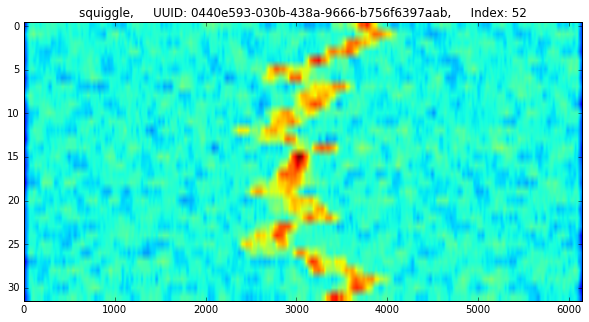

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram3),  aspect = 0.5*float(spectrogram3.shape[1]) / spectrogram3.shape[0])#, cmap=plt.get_cmap('gray'))
plt.title('%s,     UUID: %s,     Index: %s'%(aca.header()['signal_classification'],aca.header()['uuid'],index))

2006724.77574
2322927.16467


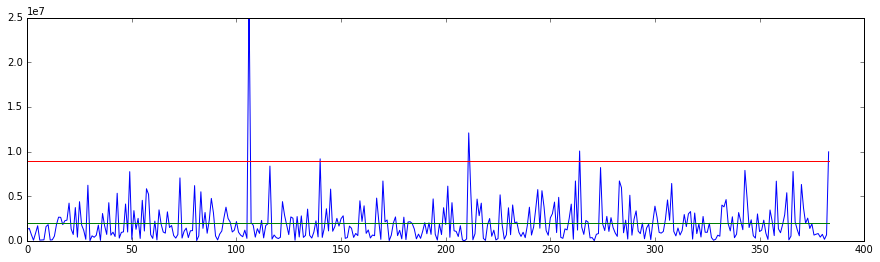

In [35]:
# Third attempt: Sample part of the noise
plt.figure(figsize=(15,4))
plt.plot(spectrogram[0][0:384])
spec_mean = np.mean(spectrogram[0][0:384])
spec_std = np.std(spectrogram[0][0:384])
spec_std_ul = spec_mean+3*spec_std
spec_std_ll = spec_mean-3*spec_std
plt.plot(np.tile(spec_mean,384))
plt.plot(np.tile(spec_std_ul,384))
plt.plot(np.tile(spec_std_ll,384))
plt.ylim([0,25000000])
print np.mean(spectrogram[0][0:384])
print np.std(spectrogram[0][0:384])

In [36]:
# Third-b attempt: Subtract the Sample part of the noise
#plt.figure(figsize=(15,4))
#plt.plot(spectrogram[0]-np.tile(spectrogram[0][0:384],16))
#plt.xlim([0,500])
#plt.ylim([0,25000000])

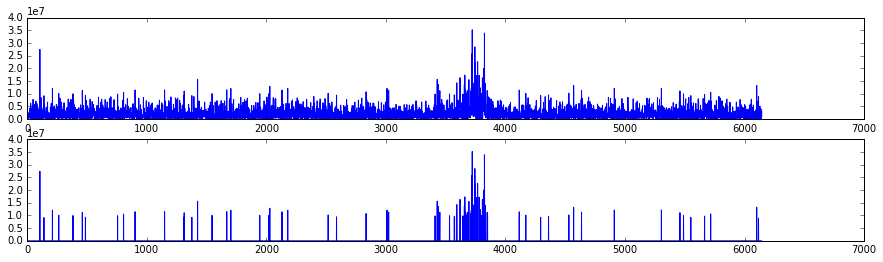

In [37]:
# Third-a attempt: Remove signals that are less than few std.dev.
spect1 = np.zeros(spectrogram[0].shape[0])
for i in range(spectrogram[0].shape[0]):
    if spectrogram[0][i] > spec_std_ul:
        spect1[i] = spectrogram[0][i]

plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
plt.plot(spectrogram[0])
plt.subplot(2,1,2)
plt.plot(spect1)

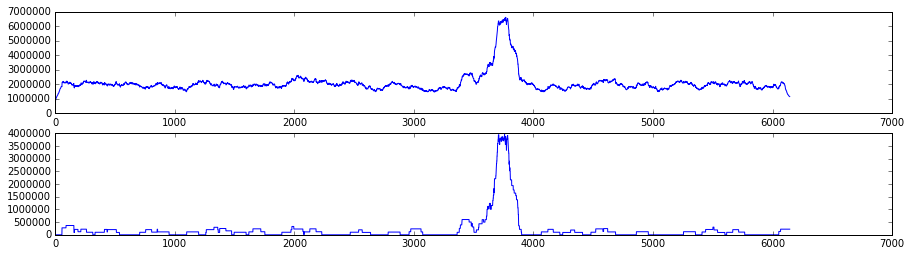

In [38]:
# Fourth attempt: use a smoothing function in combination with Third attempt
plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
plt.plot(smooth(spectrogram[0],100))
plt.subplot(2,1,2)
plt.plot(smooth(spect1,100))

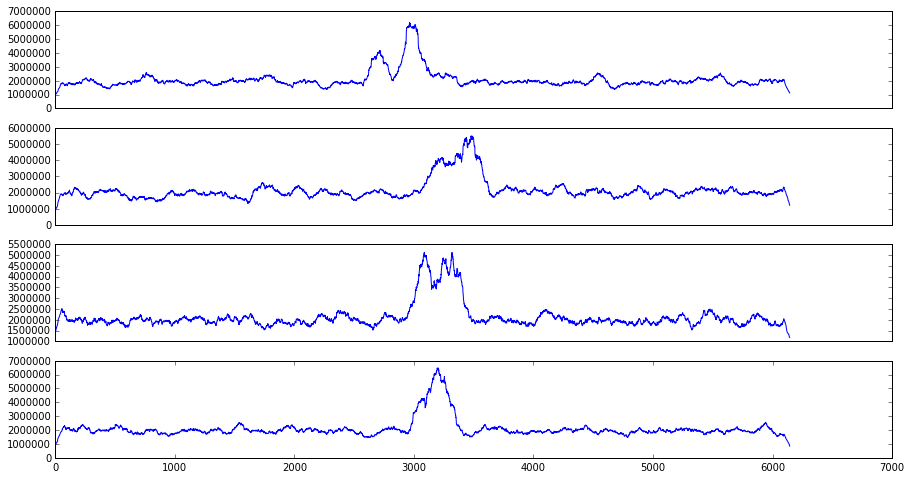

In [39]:
# Check smoothing function on multiple signals
plt.figure(figsize=(15,8))
plt.subplot(4,1,1)
plt.plot(smooth(spectrogram[6],100))
plt.xticks([])
plt.subplot(4,1,2)
plt.plot(smooth(spectrogram[7],100))
plt.xticks([])
plt.subplot(4,1,3)
plt.plot(smooth(spectrogram[8],100))
plt.xticks([])
plt.subplot(4,1,4)
plt.plot(smooth(spectrogram[9],100))
#plt.xticks([])

In [40]:
# Try FFT #2 (FFT, filter, inv.FFT) on Smoothed signals
temp_index = 4
time  = np.linspace(0,spectrogram[0].shape[0],spectrogram[0].shape[0])
signal = smooth(spectrogram[temp_index],100)#spectrogram[0]
W = fftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

cut_f_signal = f_signal.copy()
cut_f_signal[np.logical_and(W>-0.5, W<0.05)] = 0 #0.05, Remove central freq
cut_signal = irfft(cut_f_signal)

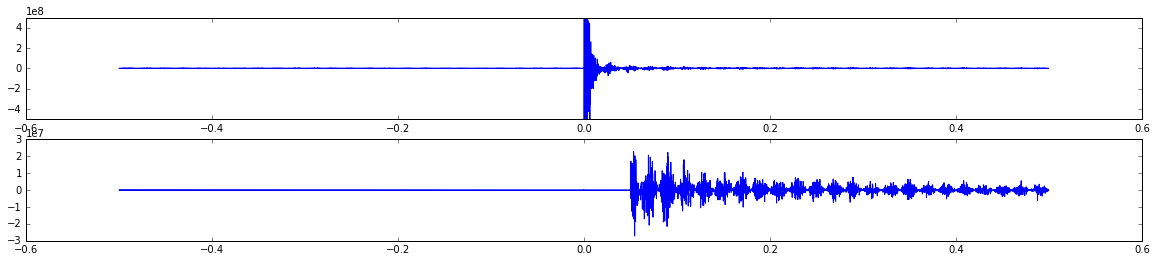

In [41]:
plt.figure(figsize=(20,4))
plt.subplot(211)
plt.plot(W,f_signal)
#plt.xlim([-1,1])
plt.ylim([-0.5e9,0.5e9])
plt.subplot(212)
plt.plot(W,cut_f_signal)
#plt.ylim([-1500,3000])
plt.show()

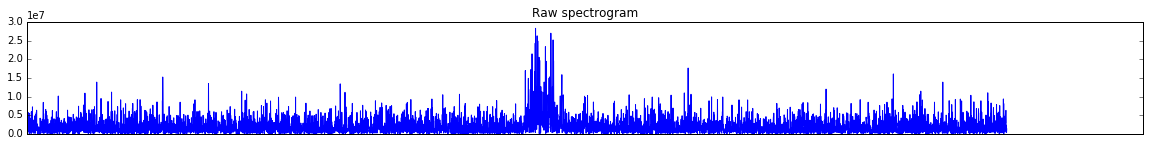

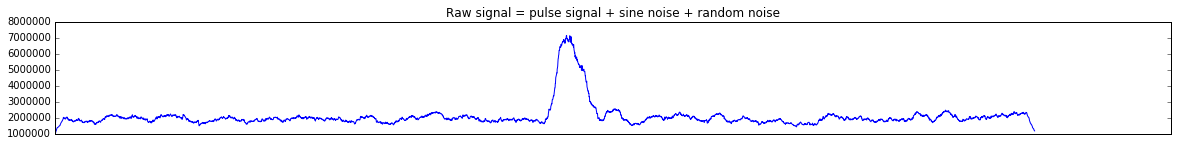

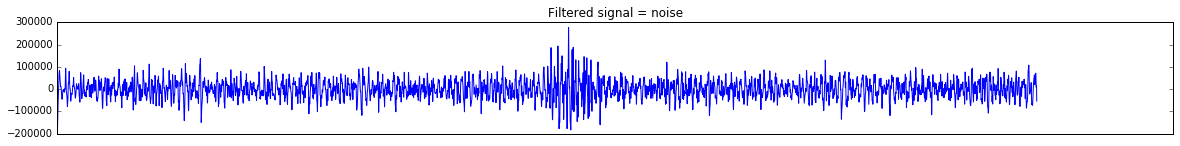

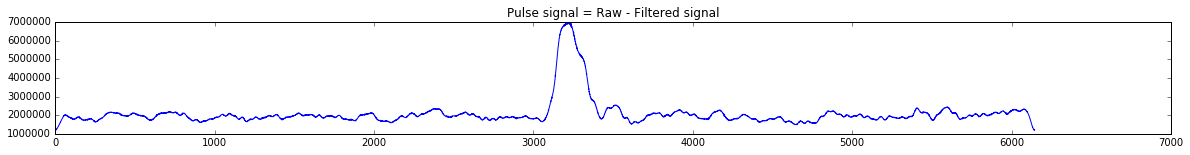

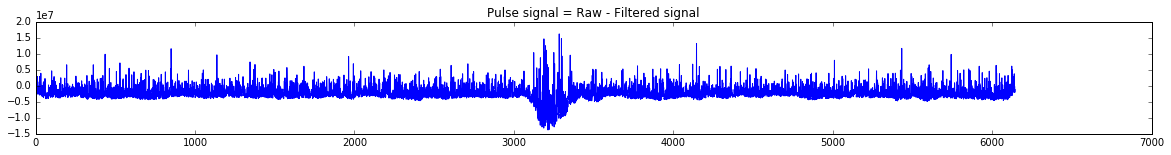

In [42]:
plt.figure(figsize=(20,2))
plt.plot(time,spectrogram[temp_index])
plt.title('Raw spectrogram')
plt.xticks([])

plt.figure(figsize=(20,2))
plt.plot(time,signal)
plt.title('Raw signal = pulse signal + sine noise + random noise')
plt.xticks([])

plt.figure(figsize=(20,2))
plt.plot(time,cut_signal) 
plt.title('Filtered signal = noise')
plt.xticks([])

plt.figure(figsize=(20,2))
plt.plot(time,signal-cut_signal)
plt.title('Pulse signal = Raw - Filtered signal')
#plt.xlim([2.5,3])

plt.figure(figsize=(20,2))
plt.plot(time,spectrogram[temp_index]-2*(signal-cut_signal))
plt.title('Pulse signal = Raw - Filtered signal')
#plt.xlim([2.5,3])

In [43]:
# Try "Second attempt" from above over entire spectrogram
spect_fftDSP2 = np.zeros(spectrogram.shape)
for cnt in range(32):
    signal2 = smooth(spectrogram[cnt],100)
    W2 = fftfreq(signal2.size, d=time[1]-time[0])
    f_signal2 = rfft(signal2)

    cut_f_signal2 = f_signal2.copy()
    cut_f_signal2[np.logical_and(W2>-5, W2<5)] = 0 #0.05, Remove central freq
    cut_signal2 = irfft(cut_f_signal2)
    spect_fftDSP2[cnt] = signal2 - cut_signal2

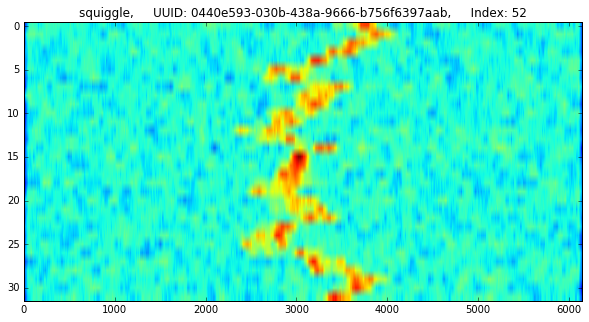

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spect_fftDSP2),  aspect = 0.5*float(spect_fftDSP2.shape[1]) / spect_fftDSP2.shape[0])#, cmap=plt.get_cmap('gray'))
plt.title('%s,     UUID: %s,     Index: %s'%(aca.header()['signal_classification'],aca.header()['uuid'],index))

In [45]:
# Smoothing seems to work the best, so smooth the entire spectrogram
# spectrogram ---> 'numpy.ndarray'. smooth(spectrogram) ---> 'list'
spectrogram2 = np.asarray([smooth(spectrogram[i],100) for i in range(32)]) 

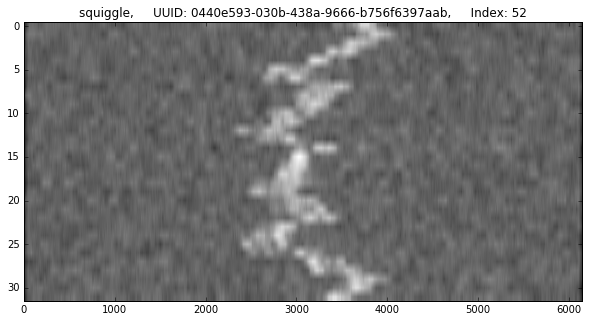

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram2),  aspect = 0.5*float(spectrogram2.shape[1]) / spectrogram2.shape[0], cmap=plt.get_cmap('gray'))
plt.title('%s,     UUID: %s,     Index: %s'%(aca.header()['signal_classification'],aca.header()['uuid'],index))

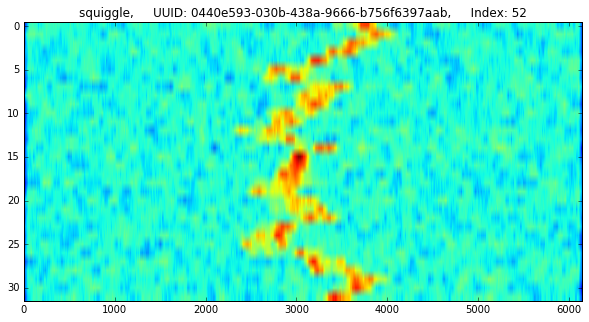

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram2),  aspect = 0.5*float(spectrogram2.shape[1]) / spectrogram2.shape[0])#, cmap=plt.get_cmap('gray'))
plt.title('%s,     UUID: %s,     Index: %s'%(aca.header()['signal_classification'],aca.header()['uuid'],index))

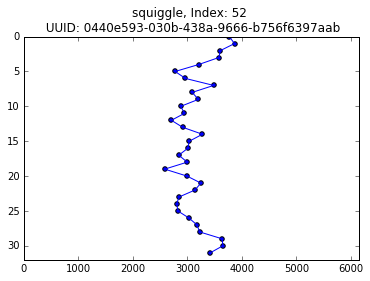

In [48]:
MaxAmps_Freq2 = spectrogram2.argmax(1)
MaxAmps_Time2 = np.arange(32)

plt.plot(MaxAmps_Freq2, MaxAmps_Time2)
plt.scatter(MaxAmps_Freq2, MaxAmps_Time2)
plt.xlim([0,6144])
plt.ylim([32,0])
plt.title('%s, Index: %s \n UUID: %s'%(aca.header()['signal_classification'],index,aca.header()['uuid']))

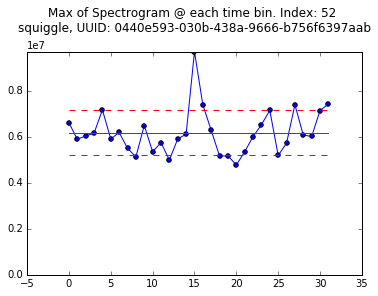

In [49]:
MaxAmps2 = spectrogram2.max(axis=1)
mean=np.tile(np.mean(spectrogram2.max(axis=1)),32)
std=np.tile(np.std(spectrogram2.max(axis=1)),32)

plt.plot(MaxAmps2)
plt.scatter(MaxAmps_Time2, MaxAmps2)
plt.plot(mean)
plt.plot(mean+1*std,'r--')
plt.plot(mean-1*std,'r--')
plt.ylim([0,spectrogram2.max()])
plt.title('Max of Spectrogram @ each time bin. Index: %s \n%s, UUID: %s\n'%(index, aca.header()['signal_classification'],aca.header()['uuid']))   